## 02_feature_engineering.ipynb

This notebook performs **feature engineering** and **correlation-based feature selection** on the cleaned CIC-IIoT dataset.
It aims to improve model performance by reducing redundancy, standardizing features, and preserving the most informative dimensions.


#### Import Libraries

In [45]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA, FastICA

# Reduction parameters (defined here so later cells can reference them)
# PCA: use float n_components to preserve explained variance (0.95 -> 95%)
PCA_PARAMS = {"n_components": 0.95, "svd_solver": "full", "random_state": 42}  # retain 95% variance
# ICA: None means keep full dimensionality by default; set an int to reduce
ICA_PARAMS = {"n_components": 19, "random_state": 42}

REDUCTION_METHOD = 'raw' 

NEAR_CONSTANT_THRESHOLD = 0.001

#### Paths

In [46]:
DATA_DIR = os.path.join("data", "merged")
FEATURE_DIR = os.path.join("data", "features")
os.makedirs(FEATURE_DIR, exist_ok=True)

#### Load & Seperate

In [47]:
# Load cleaned dataset splits (train/test) — no fallback to a combined file
train_path = os.path.join(DATA_DIR, "combined_balanced_train.csv")
test_path = os.path.join(DATA_DIR, "combined_balanced_test.csv")

# Require the two split files to exist
missing = [p for p in [train_path, test_path] if not os.path.exists(p)]
if missing:
    raise FileNotFoundError(f"Missing expected split files: {missing}. Please place train/test CSVs in {DATA_DIR}")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
# No validation split in this workflow
val_df = pd.DataFrame()

print(f"Loaded splits → train: {train_df.shape}, test: {test_df.shape}")

# Separate labels and features for each split
label_cols = ["label1", "label2", "label3", "label4", "label_full"]
labels_train = train_df[label_cols].reset_index(drop=True)
X_train = train_df.drop(columns=label_cols)

labels_val = pd.DataFrame(columns=label_cols)
X_val = pd.DataFrame(columns=X_train.columns)

labels_test = test_df[label_cols].reset_index(drop=True) if not test_df.empty else pd.DataFrame(columns=label_cols)
X_test = test_df.drop(columns=label_cols) if not test_df.empty else pd.DataFrame(columns=X_train.columns)

print('\nFeature shapes:')
print(' X_train:', X_train.shape)
print(' X_test: ', X_test.shape)

Loaded splits → train: (194926, 95), test: (83540, 95)

Feature shapes:
 X_train: (194926, 90)
 X_test:  (83540, 90)


### Initial feature inventory & manual removal

Run the analysis cell below to get a table of all features, their types,
missing ratios, unique counts and sample values. Review that table and then
edit the `COLUMNS_TO_DROP` list in the following cell to remove any
unwanted or sensitive columns (timestamps, MACs, device IDs, etc.).

- After dropping, the notebook will update `X_train`, `X_test` and
  save the dropped column list to `data/features/dropped_columns.csv` for reproducibility.

In [48]:
# AUTO DROP 1: Remove near-constant features based on unique-ratio threshold (default 0.1%)
print('Auto-drop: near-constant feature removal (threshold = 0.1% unique)')
THRESH_NEAR_CONST = NEAR_CONSTANT_THRESHOLD if 'NEAR_CONSTANT_THRESHOLD' in globals() else 0.001
n_rows = len(X_train)
nunique_ratio = X_train.nunique(dropna=True) / (n_rows if n_rows>0 else 1)
near_const_cols = nunique_ratio[nunique_ratio < THRESH_NEAR_CONST].index.tolist()
# never drop label columns
protected = [c for c in label_cols if c in X_train.columns]
near_const_cols = [c for c in near_const_cols if c not in protected]
# Step 1: List candidates
if near_const_cols:
    print(f"Found {len(near_const_cols)} near-constant candidate columns (examples): {near_const_cols[:20]}")
else:
    print('No near-constant candidate columns found with the given threshold.')
# Step 2: Save candidate list for review/reproducibility
os.makedirs(FEATURE_DIR, exist_ok=True)
path_nc = os.path.join(FEATURE_DIR, 'dropped_near_constant.csv')
pd.DataFrame({'dropped_column': near_const_cols}).to_csv(path_nc, index=False)
print('Saved near-constant candidate list to:', path_nc)
# Step 3: Proceed to drop the candidates (if any)
if near_const_cols:
    print('Dropping listed near-constant columns now...')
    X_train.drop(columns=near_const_cols, inplace=True, errors='ignore')
    X_val.drop(columns=near_const_cols, inplace=True, errors='ignore')
    X_test.drop(columns=near_const_cols, inplace=True, errors='ignore')
    print('Dropped columns. New shapes ->', 'X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
else:
    print('No columns to drop.')

Auto-drop: near-constant feature removal (threshold = 0.1% unique)
Found 27 near-constant candidate columns (examples): ['device_name', 'device_mac', 'log_data-types', 'log_data-types_count', 'log_messages_count', 'network_header-length_max', 'network_header-length_min', 'network_ip-flags_max', 'network_ip-flags_min', 'network_ip-length_min', 'network_ips_src_count', 'network_macs_all_count', 'network_macs_dst_count', 'network_macs_src_count', 'network_mss_max', 'network_mss_min', 'network_packet-size_min', 'network_payload-length_min', 'network_protocols_all_count', 'network_protocols_dst_count']
Saved near-constant candidate list to: data\features\dropped_near_constant.csv
Dropping listed near-constant columns now...
Dropped columns. New shapes -> X_train: (194926, 63) X_val: (0, 63) X_test: (83540, 63)


In [49]:
# AUTO DROP 2: Remove identity-like / sensitive columns by heuristic keywords
print('Auto-drop: identity-like columns (mac, device, host, ip, timestamp, time, date, name)')
keywords = ['mac','device','host','ip','timestamp','time','date','name']
cols = X_train.columns.tolist()
identity_cols = [c for c in cols if any(k in c.lower() for k in keywords)]
# exclude label columns just in case
identity_cols = [c for c in identity_cols if c not in label_cols]
# Step 1: List candidates
if identity_cols:
    print(f"Found {len(identity_cols)} identity-like candidate columns (examples): {identity_cols[:20]}")
else:
    print('No identity-like candidate columns detected by keyword heuristic.')
# Step 2: Save candidate list
os.makedirs(FEATURE_DIR, exist_ok=True)
path_id = os.path.join(FEATURE_DIR, 'dropped_identity_like.csv')
pd.DataFrame({'dropped_column': identity_cols}).to_csv(path_id, index=False)
print('Saved identity-like candidate list to:', path_id)
# Step 3: Drop the listed candidates
if identity_cols:
    print('Dropping listed identity-like columns now...')
    X_train.drop(columns=identity_cols, inplace=True, errors='ignore')
    X_val.drop(columns=identity_cols, inplace=True, errors='ignore')
    X_test.drop(columns=identity_cols, inplace=True, errors='ignore')
    print('Dropped identity-like columns. New shapes ->', 'X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
else:
    print('No columns to drop.')

Auto-drop: identity-like columns (mac, device, host, ip, timestamp, time, date, name)
Found 20 identity-like candidate columns (examples): ['timestamp', 'timestamp_start', 'timestamp_end', 'network_ip-flags_avg', 'network_ip-flags_std_deviation', 'network_ip-length_avg', 'network_ip-length_max', 'network_ip-length_std_deviation', 'network_ips_all', 'network_ips_all_count', 'network_ips_dst', 'network_ips_dst_count', 'network_ips_src', 'network_macs_all', 'network_macs_dst', 'network_macs_src', 'network_time-delta_avg', 'network_time-delta_max', 'network_time-delta_min', 'network_time-delta_std_deviation']
Saved identity-like candidate list to: data\features\dropped_identity_like.csv
Dropping listed identity-like columns now...
Dropped identity-like columns. New shapes -> X_train: (194926, 43) X_val: (0, 43) X_test: (83540, 43)


#### Feature Overview & Statistics

Number of numeric columns: 37
Number of categorical columns: 6


,Non-Null Count,Unique Count,Data Type
log_data-ranges_avg,194926,4116,float64
log_data-ranges_max,194926,531,float64
log_data-ranges_min,194926,505,float64
log_data-ranges_std_deviation,194926,6910,float64
log_interval-messages,194926,3521,float64
network_fragmentation-score,194926,313,float64
network_fragmented-packets,194926,4334,int64
network_header-length_avg,194926,295,float64
network_header-length_std_deviation,194926,295,float64
network_interval-packets,194926,85160,float64


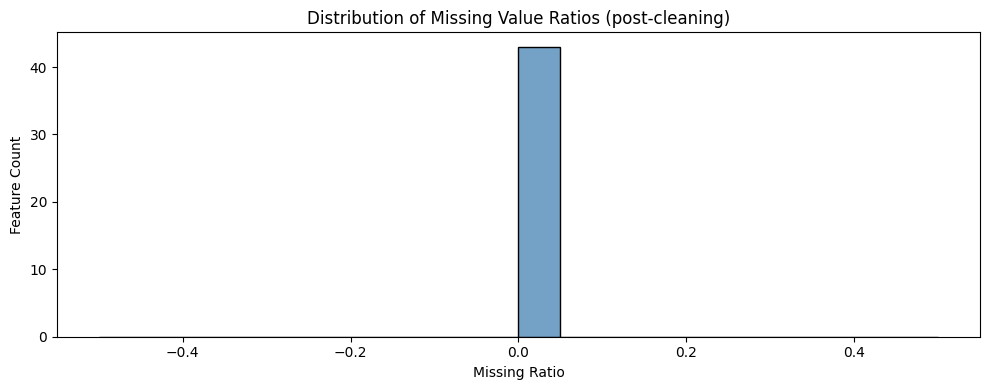

In [50]:
# Basic stats
# Ensure `X` refers to the current training features (used by following cells)
X = X_train.copy()
print("Number of numeric columns:", X.select_dtypes(include=["number"]).shape[1])
print("Number of categorical columns:", X.select_dtypes(exclude=["number"]).shape[1])

# Feature summary
feature_summary = pd.DataFrame({
    "Non-Null Count": X.notnull().sum(),
    "Unique Count": X.nunique(),
    "Data Type": X.dtypes
}).sort_values(by="Non-Null Count", ascending=False)

display(feature_summary.head(10))

# Quick visualization of missing ratios (sanity check)
missing_ratio = X.isnull().mean().sort_values(ascending=False)
plt.figure(figsize=(10,4))
sns.histplot(missing_ratio, bins=20, kde=False, color="steelblue")
plt.title("Distribution of Missing Value Ratios (post-cleaning)")
plt.xlabel("Missing Ratio")
plt.ylabel("Feature Count")
plt.tight_layout()
plt.show()

#### Correlation Analysis

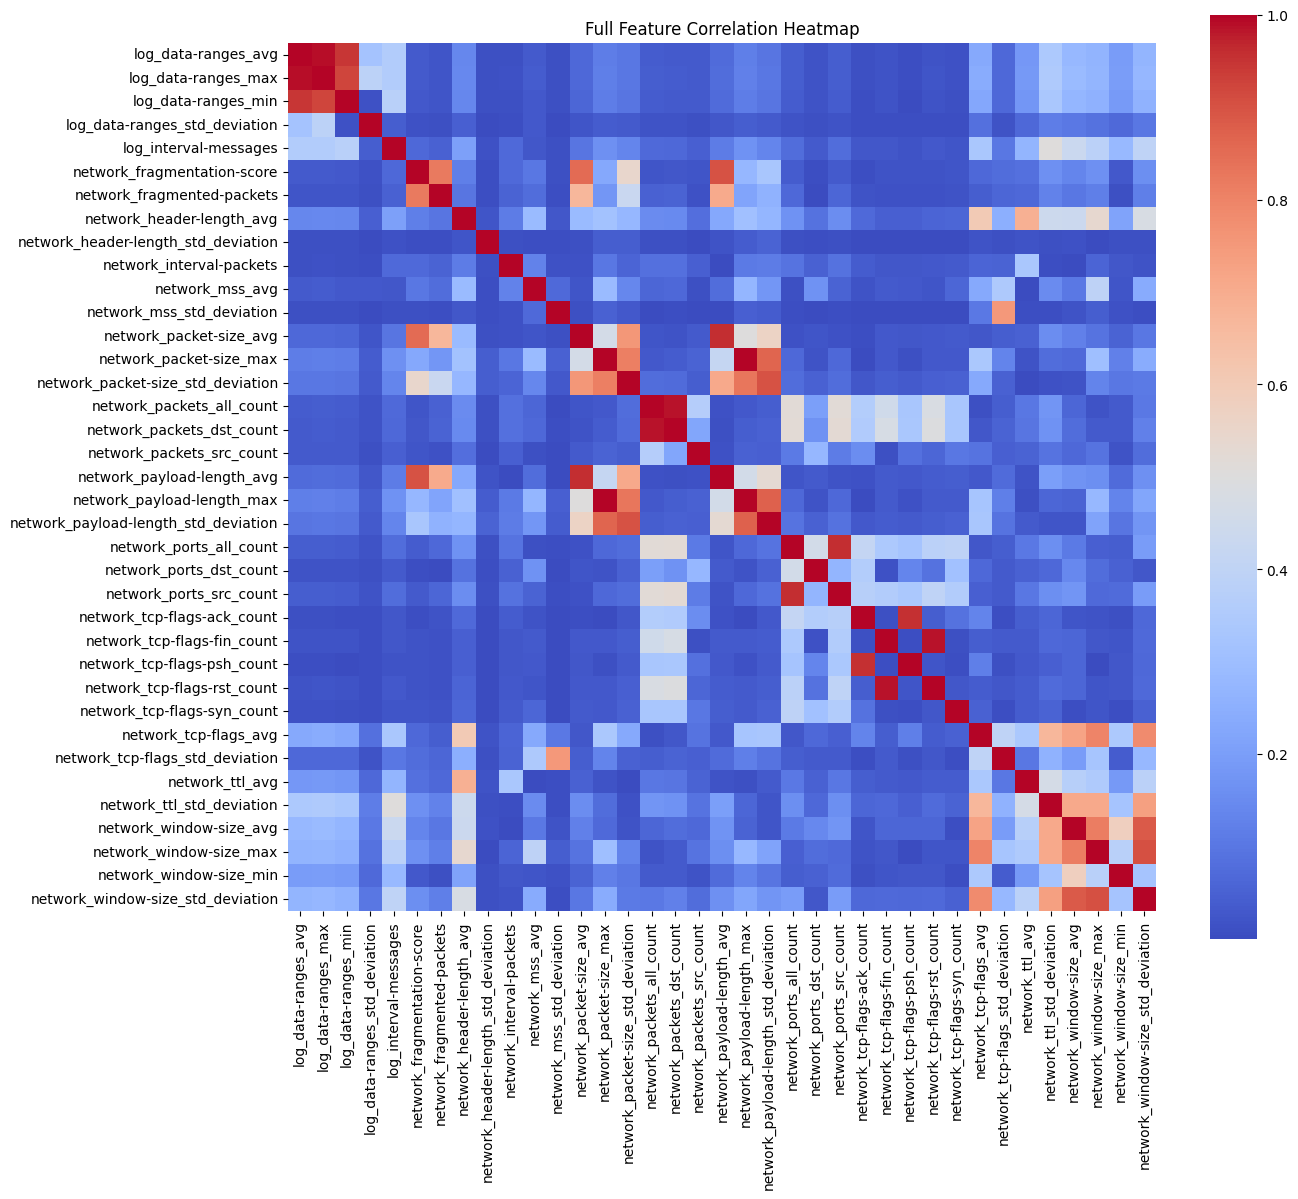

→ Found 7 highly correlated features (|corr| > 0.95)
   Example: ['log_data-ranges_max', 'network_packets_dst_count', 'network_payload-length_avg', 'network_payload-length_max', 'network_ports_src_count', 'network_tcp-flags-psh_count', 'network_tcp-flags-rst_count'] ...
 Remaining features after correlation filtering: 36


In [51]:
# Compute full correlation matrix (numeric-only)
numeric_cols = X.select_dtypes(include=["number"]).columns
corr_matrix = X[numeric_cols].corr().abs()

# Visualize full heatmap (use smaller figure size only if too big)
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", square=True, cbar=True)
plt.title("Full Feature Correlation Heatmap")
plt.show()

# Identify highly correlated feature pairs (threshold > 0.95)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_cols = [col for col in upper_tri.columns if any(upper_tri[col] > 0.95)]

print(f"→ Found {len(high_corr_cols)} highly correlated features (|corr| > 0.95)")
if len(high_corr_cols) > 0:
    print(f"   Example: {high_corr_cols[:10]} ...")

# Drop them from X
X.drop(columns=high_corr_cols, inplace=True)
print(f" Remaining features after correlation filtering: {X.shape[1]}")


#### Encoding Categorical Features

In [52]:
cat_cols = X.select_dtypes(exclude=["number"]).columns
low_card_cols = [c for c in cat_cols if X[c].nunique() <= 20]  
high_card_cols = [c for c in cat_cols if X[c].nunique() > 20]

print(f"Low-cardinality columns to encode: {low_card_cols}")
print(f"Skipping high-cardinality columns: {high_card_cols[:5]} ... ({len(high_card_cols)} total)")

if len(low_card_cols) > 0:
    X = pd.get_dummies(X, columns=low_card_cols, drop_first=True)
else:
    print("No low-cardinality categorical columns detected.")

Low-cardinality columns to encode: []
Skipping high-cardinality columns: ['network_ports_all', 'network_ports_dst', 'network_ports_src', 'network_protocols_all', 'network_protocols_dst'] ... (6 total)
No low-cardinality categorical columns detected.


#### Feature Scaling

In [53]:
# Scaling + Encoding: fit on TRAIN only, transform VAL/TEST
print("\nScaling features (fit on TRAIN only)...")

# Identify numeric vs non-numeric and save non-numeric copies for encoding
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = [c for c in X_train.columns if c not in numeric_cols]
non_numeric_train = X_train[non_numeric_cols].copy() if non_numeric_cols else pd.DataFrame()
non_numeric_val = X_val[non_numeric_cols].copy() if (non_numeric_cols and not X_val.empty) else pd.DataFrame(columns=non_numeric_cols)
non_numeric_test = X_test[non_numeric_cols].copy() if (non_numeric_cols and not X_test.empty) else pd.DataFrame(columns=non_numeric_cols)
if non_numeric_cols:
    print(f"Found non-numeric columns to encode later: {non_numeric_cols[:20]}{'...' if len(non_numeric_cols)>20 else ''}")
    os.makedirs(FEATURE_DIR, exist_ok=True)
    path_nn = os.path.join(FEATURE_DIR, 'non_numeric_columns_for_encoding.csv')
    pd.DataFrame({'non_numeric_column': non_numeric_cols}).to_csv(path_nn, index=False)
    print('Saved non-numeric column list to:', path_nn)
    # Drop non-numeric before scaling (we will encode them separately below)
    X_train_num = X_train.drop(columns=non_numeric_cols, errors='ignore')
    X_val_num = X_val.drop(columns=non_numeric_cols, errors='ignore') if not X_val.empty else pd.DataFrame(columns=X_train_num.columns)
    X_test_num = X_test.drop(columns=non_numeric_cols, errors='ignore') if not X_test.empty else pd.DataFrame(columns=X_train_num.columns)
else:
    X_train_num = X_train.copy()
    X_val_num = X_val.copy() if not X_val.empty else pd.DataFrame(columns=X_train_num.columns)
    X_test_num = X_test.copy() if not X_test.empty else pd.DataFrame(columns=X_train_num.columns)

# Standard scaler for numeric features
std_scaler = StandardScaler()
X_train_scaled = pd.DataFrame(std_scaler.fit_transform(X_train_num), columns=X_train_num.columns)
X_val_scaled = pd.DataFrame(std_scaler.transform(X_val_num), columns=X_train_num.columns) if not X_val_num.empty else pd.DataFrame(columns=X_train_num.columns)
X_test_scaled = pd.DataFrame(std_scaler.transform(X_test_num), columns=X_train_num.columns) if not X_test_num.empty else pd.DataFrame(columns=X_train_num.columns)

print(f"Numeric scaled shapes → train: {X_train_scaled.shape}, val: {X_val_scaled.shape}, test: {X_test_scaled.shape}")

# Now encode the non-numeric columns and merge with scaled numeric features
# Classify non-numeric into low-cardinality (one-hot) and high-cardinality (frequency)
low_card_cols = []
high_card_cols = []
for c in non_numeric_cols:
    n_unique = non_numeric_train[c].nunique(dropna=True) if not non_numeric_train.empty else 0
    if n_unique <= 20:
        low_card_cols.append(c)
    else:
        high_card_cols.append(c)
# Save lists for review
pd.DataFrame({'low_cardinality': low_card_cols}).to_csv(os.path.join(FEATURE_DIR, 'encoded_low_cardinality_cols.csv'), index=False)
pd.DataFrame({'high_cardinality': high_card_cols}).to_csv(os.path.join(FEATURE_DIR, 'encoded_high_cardinality_cols.csv'), index=False)
print(f"Low-cardinality cols (one-hot): {low_card_cols}")
print(f"High-cardinality cols (frequency-encoded): {high_card_cols}")

# One-hot encode low-cardinality cols on saved non-numeric parts and align
if low_card_cols:
    low_train = pd.get_dummies(non_numeric_train[low_card_cols].fillna('<<MISSING>>'), columns=low_card_cols, drop_first=False)
    low_val = pd.get_dummies(non_numeric_val[low_card_cols].fillna('<<MISSING>>'), columns=low_card_cols, drop_first=False) if not non_numeric_val.empty else pd.DataFrame(columns=low_train.columns)
    low_test = pd.get_dummies(non_numeric_test[low_card_cols].fillna('<<MISSING>>'), columns=low_card_cols, drop_first=False) if not non_numeric_test.empty else pd.DataFrame(columns=low_train.columns)
    # align columns
    low_val = low_val.reindex(columns=low_train.columns, fill_value=0)
    low_test = low_test.reindex(columns=low_train.columns, fill_value=0)
else:
    low_train = pd.DataFrame()
    low_val = pd.DataFrame()
    low_test = pd.DataFrame()

# Frequency-encode high-cardinality cols using TRAIN frequencies
freq_train_parts = []
freq_val_parts = []
freq_test_parts = []
for c in high_card_cols:
    train_vals = non_numeric_train[c].fillna('<<MISSING>>')
    freq = train_vals.value_counts(normalize=True)
    col_name = f"{c}__freq"
    freq_train_parts.append(train_vals.map(freq).fillna(0).rename(col_name))
    if not non_numeric_val.empty:
        val_vals = non_numeric_val[c].fillna('<<MISSING>>')
        freq_val_parts.append(val_vals.map(freq).fillna(0).rename(col_name))
    if not non_numeric_test.empty:
        test_vals = non_numeric_test[c].fillna('<<MISSING>>')
        freq_test_parts.append(test_vals.map(freq).fillna(0).rename(col_name))

freq_train = pd.concat(freq_train_parts, axis=1) if freq_train_parts else pd.DataFrame()
freq_val = pd.concat(freq_val_parts, axis=1) if freq_val_parts else pd.DataFrame()
freq_test = pd.concat(freq_test_parts, axis=1) if freq_test_parts else pd.DataFrame()

# Combine scaled numeric + encoded non-numeric parts
X_train_combined = pd.concat([X_train_scaled.reset_index(drop=True), low_train.reset_index(drop=True), freq_train.reset_index(drop=True)], axis=1) if not X_train_scaled.empty else pd.DataFrame()
X_val_combined = pd.concat([X_val_scaled.reset_index(drop=True) if not X_val_scaled.empty else pd.DataFrame(columns=X_train_combined.columns), low_val.reset_index(drop=True), freq_val.reset_index(drop=True)], axis=1) if (not X_val_scaled.empty or not low_val.empty or not freq_val.empty) else pd.DataFrame()
X_test_combined = pd.concat([X_test_scaled.reset_index(drop=True) if not X_test_scaled.empty else pd.DataFrame(columns=X_train_combined.columns), low_test.reset_index(drop=True), freq_test.reset_index(drop=True)], axis=1) if (not X_test_scaled.empty or not low_test.empty or not freq_test.empty) else pd.DataFrame()

# Align columns to TRAIN
if not X_train_combined.empty:
    X_val_combined = X_val_combined.reindex(columns=X_train_combined.columns, fill_value=0) if not X_val_combined.empty else pd.DataFrame(columns=X_train_combined.columns)
    X_test_combined = X_test_combined.reindex(columns=X_train_combined.columns, fill_value=0) if not X_test_combined.empty else pd.DataFrame(columns=X_train_combined.columns)

print(f"Final encoded+scaled shapes → train: {X_train_combined.shape}, val: {X_val_combined.shape}, test: {X_test_combined.shape}")
# replace scaled variables with combined versions for downstream cells
X_train_scaled = X_train_combined
X_val_scaled = X_val_combined
X_test_scaled = X_test_combined
print('Saved encoding metadata files in data/features (low/high cardinality lists).')



Scaling features (fit on TRAIN only)...
Found non-numeric columns to encode later: ['network_ports_all', 'network_ports_dst', 'network_ports_src', 'network_protocols_all', 'network_protocols_dst', 'network_protocols_src']
Saved non-numeric column list to: data\features\non_numeric_columns_for_encoding.csv
Numeric scaled shapes → train: (194926, 37), val: (0, 37), test: (83540, 37)
Low-cardinality cols (one-hot): []
High-cardinality cols (frequency-encoded): ['network_ports_all', 'network_ports_dst', 'network_ports_src', 'network_protocols_all', 'network_protocols_dst', 'network_protocols_src']
Final encoded+scaled shapes → train: (194926, 43), val: (0, 43), test: (83540, 43)
Saved encoding metadata files in data/features (low/high cardinality lists).


#### Dimensionality Reduction (PCA / ICA / none)

This section supports multiple **unsupervised** reduction methods. Set `REDUCTION_METHOD` to one of: `"pca"`, `"ica"` or `"none"` (no reduction).

Notes:
- **PCA** and **ICA** are unsupervised and do not use labels.
- Always **fit reducers only on training folds** (or inside a CV/pipeline) and apply `transform` on validation/test to avoid data leakage.

In [54]:
# Reduction: fit reducer on TRAIN only, transform VAL/TEST
print('\nApplying dimensionality reduction (fit on TRAIN only)...')

# Use the REDUCTION_METHOD defined earlier if present; otherwise default to 'none'

if REDUCTION_METHOD == "pca":
    reducer = PCA(**PCA_PARAMS)
    X_train_red = reducer.fit_transform(X_train_scaled)
    X_val_red = reducer.transform(X_val_scaled) if not X_val.empty else np.empty((0, X_train_red.shape[1]))
    X_test_red = reducer.transform(X_test_scaled) if not X_test.empty else np.empty((0, X_train_red.shape[1]))
    cols = [f"PC_{i+1}" for i in range(X_train_red.shape[1])]

elif REDUCTION_METHOD == "ica":
    reducer = FastICA(**ICA_PARAMS, max_iter=10000)
    X_train_red = reducer.fit_transform(X_train_scaled)
    X_val_red = reducer.transform(X_val_scaled) if not X_val.empty else np.empty((0, X_train_red.shape[1]))
    X_test_red = reducer.transform(X_test_scaled) if not X_test.empty else np.empty((0, X_train_red.shape[1]))
    cols = [f"IC_{i+1}" for i in range(X_train_red.shape[1])]

elif REDUCTION_METHOD == "raw":
    # Keep scaled features (Standard scaled)
    X_train_red = X_train_scaled.values
    X_val_red = X_val_scaled.values if not X_val.empty else np.empty((0, X_train_red.shape[1]))
    X_test_red = X_test_scaled.values if not X_test.empty else np.empty((0, X_train_red.shape[1]))
    cols = X_train_scaled.columns.tolist()

else:
    raise ValueError(f"Unknown REDUCTION_METHOD: {REDUCTION_METHOD}")

# Convert to DataFrames
X_reduced_train_df = pd.DataFrame(X_train_red, columns=cols)
X_reduced_val_df = pd.DataFrame(X_val_red, columns=cols) if X_val_red.size else pd.DataFrame(columns=cols)
X_reduced_test_df = pd.DataFrame(X_test_red, columns=cols) if X_test_red.size else pd.DataFrame(columns=cols)

print(f"Reduced shapes → train: {X_reduced_train_df.shape}, val: {X_reduced_val_df.shape}, test: {X_reduced_test_df.shape}")



Applying dimensionality reduction (fit on TRAIN only)...
Reduced shapes → train: (194926, 43), val: (0, 43), test: (83540, 43)


In [55]:
# Combine reduced features with labels for each split and save
engineered_train_df = pd.concat([X_reduced_train_df.reset_index(drop=True), labels_train.reset_index(drop=True)], axis=1)
engineered_val_df = pd.concat([X_reduced_val_df.reset_index(drop=True), labels_val.reset_index(drop=True)], axis=1) if not labels_val.empty else pd.DataFrame()
engineered_test_df = pd.concat([X_reduced_test_df.reset_index(drop=True), labels_test.reset_index(drop=True)], axis=1) if not labels_test.empty else pd.DataFrame()

print(f"Final engineered shapes (train/val/test): {engineered_train_df.shape}, {engineered_val_df.shape if not engineered_val_df.empty else 'empty'}, {engineered_test_df.shape if not engineered_test_df.empty else 'empty'}")
method_dir = os.path.join(FEATURE_DIR, REDUCTION_METHOD)
os.makedirs(method_dir, exist_ok=True)
train_path = os.path.join(method_dir, f"combined_engineered_{REDUCTION_METHOD}_train.csv")
val_path = os.path.join(method_dir, f"combined_engineered_{REDUCTION_METHOD}_val.csv")
test_path = os.path.join(method_dir, f"combined_engineered_{REDUCTION_METHOD}_test.csv")

engineered_train_df.to_csv(train_path, index=False)
if not engineered_val_df.empty:
    engineered_val_df.to_csv(val_path, index=False)
if not engineered_test_df.empty:
    engineered_test_df.to_csv(test_path, index=False)

print(f"\nSaved engineered feature files:\n - {train_path}\n - {val_path if not engineered_val_df.empty else '(no val file)'}\n - {test_path if not engineered_test_df.empty else '(no test file)'}")

Final engineered shapes (train/val/test): (194926, 48), empty, (83540, 48)

Saved engineered feature files:
 - data\features\raw\combined_engineered_raw_train.csv
 - (no val file)
 - data\features\raw\combined_engineered_raw_test.csv
